In [1]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona

import zipfile

In [2]:
aoi = gpd.read_file('RCCR_working_areas/RCCR_working_areas_poly.shp')
aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Name        2 non-null      object  
 1   descriptio  0 non-null      object  
 2   timestamp   0 non-null      object  
 3   begin       0 non-null      object  
 4   end         0 non-null      object  
 5   altitudeMo  0 non-null      object  
 6   tessellate  2 non-null      int64   
 7   extrude     2 non-null      int64   
 8   visibility  2 non-null      int64   
 9   drawOrder   0 non-null      object  
 10  icon        0 non-null      object  
 11  geometry    2 non-null      geometry
dtypes: geometry(1), int64(3), object(8)
memory usage: 320.0+ bytes


In [3]:
golfo_dulce = aoi.drop([aoi.index[0]])
golfo_dulce.to_file("RCCR_working_areas/golfo_dulce_aoi.json", driver="GeoJSON")

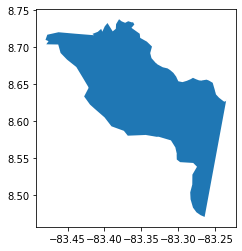

In [4]:
golfo_dulce['geometry'].plot()


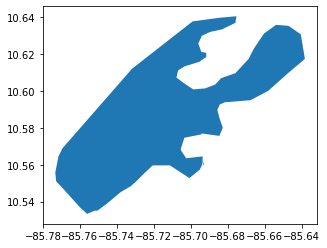

In [7]:
bahia_colebra = aoi.drop([aoi.index[1]])
bahia_colebra.to_file("RCCR_working_areas/bahia_colebra.json", driver="GeoJSON")
bahia_colebra['geometry'].plot()

In [8]:
user = 'asindic' 
password = 'ryan-dusty-grey-sky' 

api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [7]:
footprint = geojson_to_wkt(geojson_obj=read_geojson('RCCR_working_areas/golfo_dulce_aoi.json'))


In [8]:
products = api.query(footprint,
                     date = ('20160101', '20200101'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10))
len(products)


18

In [10]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['beginposition'], ascending=[True])

In [111]:
image_uuid = products_gdf_sorted['uuid'][1]
prod_download = api.download(image_uuid)

Downloading: 100%|██████████| 1.05G/1.05G [03:12<00:00, 5.46MB/s]
MD5 checksumming: 100%|██████████| 1.05G/1.05G [00:02<00:00, 389MB/s]


In [112]:
prod_download

{'id': 'b0484750-8256-4098-8bc2-296204f068e2',
 'title': 'S2A_MSIL2A_20190106T160511_N0211_R054_T17PKK_20190106T200509',
 'size': 1053562026,
 'md5': 'F9778CAA1942CDC917EB022C39EDB049',
 'date': datetime.datetime(2019, 1, 6, 16, 5, 11, 24000),
 'footprint': 'POLYGON((-83.72888 9.036587447829426,-82.73059 9.042658531194327,-82.726105 8.049938736781794,-83.72183 8.044543172576688,-83.72888 9.036587447829426))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('b0484750-8256-4098-8bc2-296204f068e2')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2019, 1, 6, 23, 39, 11, 23000),
 'Ingestion Date': datetime.datetime(2019, 1, 6, 23, 32, 56, 890000),
 'path': './S2A_MSIL2A_20190106T160511_N0211_R054_T17PKK_20190106T200509.zip',
 'downloaded_bytes': 995890346}

In [118]:
filename = prod_download['title']+ '.zip'
targetdir = 'data'
with zipfile.ZipFile(filename,"r") as zip_ref:
    zip_ref.extractall(targetdir)

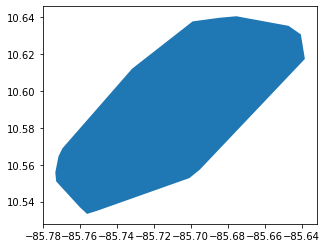

In [29]:
bahia_colebra_ch = bahia_colebra
bahia_colebra_ch['geometry'] = bahia_colebra['geometry'].convex_hull
bahia_colebra_ch.to_file("RCCR_working_areas/bahia_colebra_ch.json", driver="GeoJSON")
bahia_colebra_ch['geometry'].plot()




In [30]:
footprint = geojson_to_wkt(geojson_obj=read_geojson('RCCR_working_areas/bahia_colebra_ch.json'))

products = api.query(footprint,
                     date = ('20160101', '20200101'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-1C',
                     cloudcoverpercentage = (0,10))
len(products)

72